**MOFA** algorithm for Desulfovibrio vulgar is and Methanococcus maripaludis.
upload S_DV_MM and run

In [ ]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()


!pip install pandas openpyxl

In [6]:
import pandas as pd
import re

Sij = pd.read_excel('/content/S_DV_MM.xlsx', 'Sheet1',index_col=0) # stochiometric matrix

m= pd.read_excel('/content/S_DV_MM.xlsx', 'Sheet3')
r= pd.read_excel('/content/S_DV_MM.xlsx', 'Sheet2')
l=pd.read_excel('/content/S_DV_MM.xlsx', 'Sheet4')
u=pd.read_excel('/content/S_DV_MM.xlsx', 'Sheet5')

rxns=r['rxns'].tolist()
mets=m['mets'].tolist()
lb=l['lb'].tolist()
ub=u['ub'].tolist()

substring='EXCom_uptake'
indices = [i for i, s in enumerate(rxns) if substring in s]
uptake_rxns_indices = [rxns[i] for i in indices]

uptake_species1 = [n for n in uptake_rxns_indices if 'species1' in n]

uptake_species2=[n for n in uptake_rxns_indices if 'species2' in n]

substring='EXCom_export'
indices = [i for i, s in enumerate(rxns) if substring in s]
export_rxns_indices = [rxns[i] for i in indices]

big_M=1000000

Exc_indice = [i for i, s in enumerate(rxns) if 'EXCom_' in s]
Exc = [rxns[i] for i in Exc_indice]


Lactate_exp_ub=[26.2881147315541, 34.996169552135, 55.7372396180297,54.9275859337374,55.7888662316969,59.3735064819825,62.3147051593253]
Lactate_exp_lb=[20.8851730029806,	29.3551333516825,	38.15307451503,	40.0844667506394,	41.7981511890465,	49.7421168914241,	58.4898831674007]
Lactate_exp_avg=[23.8248928,32.50065803,47.41935057,47.98588519,49.28637243,55.10890069,61.01241835]


Hydrogen_exp_ub=[0.0183112358312035, 0.00283089154208302,0.0027496716423156,0.0147648015103097,0.0095392140032569,
                 0.00729679932303724,0.00900491116700013]

Hydrogen_exp_lb=[0.0164231257662968,0.013514634410155,0.00756497336627898,0.00190700604765735,0.00455114138079566,
                 0.0134034756171473,0.012197968570737]

Hydrogen_exp_avg=[0.017367181,0.005341871,0.005024663,0.012337138,0.00344005,0.012650168,0.012293159]

time_interval=[50,32,12,12,14,31,47]

Env_uptake=['EX_uptake_AcOH(e)[c]_[Env]','EX_uptake_CO2(e)[c]_[Env]','EX_uptake_Form(e)[c]_[Env]',
            'EX_uptake_H(e)[c]_[Env]','EX_uptake_H2S(e)[c]_[Env]']

Env_indice = [i for i, s in enumerate(rxns) if s in Env_uptake]
for i in Env_indice:
    ub[i] = 0


In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import time
import numpy as np

F1=F2=1
Biomass_MM = []
Biomass_DV  = []
Biomass_Total=[]
Acetate=[]
Carbon_dioxide=[]
Methane=[]

for i in range(len(Lactate_exp_ub)):

    lb[220] = Hydrogen_exp_ub[i]#  #EX_uptake_H2(e)[c]_[Env]
    ub[220] = Hydrogen_exp_ub[i]#
    ub[219]=0

    lb[228] =Lactate_exp_ub[i]#/0.385#/0.385 #uptake_Lac_MM
    ub[228] =Lactate_exp_ub[i]#/0.385

    ub[204]=0

    model = ConcreteModel()

    model.N = Set(initialize=rxns)

    model.M = Set(initialize=mets)

    biomass_id=['M82_species1','D89_species2']

    model.biomass = Set(initialize=biomass_id, within=model.N)

    model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

    model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

    model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

        ##############################################################################################
        #              Create Parameters
        ##############################################################################################

    model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
    model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

        ##############################################################################################
        #              Create Variables
        ##############################################################################################

    index_to_list = {k: i for i, k in enumerate(model.N)}

    def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

    model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

    model.u_1=pyo.Var(model.N)

    model.lamda_1=pyo.Var(model.M)

    model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


    model.u_2=pyo.Var(model.N)

    model.lamda_2=pyo.Var(model.M)

    model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    ##############################################################################################
        #                   The objective function
    ##############################################################################################

    model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

    S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

    def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
    model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

    model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]>= model.u_1[biomass_id[0]] )

    model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]>=model.u_2[biomass_id[1]] )
    big_M=100000000000000

    def Export_couple_Biomass_rule(model, export):
        if 'species1' in export:
            return model.v[export] <= big_M* model.v[biomass_id[0]]
        return model.v[export] <= big_M* model.v[biomass_id[1]]

    model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)



    def Zero_const_species_rule(model, r):
     if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')

        # check that the export reaction exists
        if rr in model.v:
            return model.v[r] * model.v[rr] == 0
        else:
            return pyo.Constraint.Skip
     else:
        return pyo.Constraint.Skip
    model.zero_const = pyo.Constraint(model.N, rule=Zero_const_species_rule)

    ##############################################################################################
        #                   (Inner-problem species1) constraint F.A for species 1
    ###############################################################################################
    def massbalance_species1_rule(model,m):
        return sum(S[m,n]*model.u_1[n] for n in model.N)==0

    model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

    def UB_const_species1_rule(model, r):
            if r not in model.uptake_rxns_species1:
                return model.u_1[r] <= model.ub[r]
            return  model.u_1[r] <= model.v[r]
    model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

    def LB_const_species1_rule(model, r):
        return -1*model.u_1[r] <= -1*model.lb[r]
    model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


    i_biomass=0;
    def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
            return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

        return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

    model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

    model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                      sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                      sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                      sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

    ##############################################################################################
        #                   (Inner-problem species2) constraint F.A for species 2
    ###############################################################################################

    def massbalance_species2_rule(model,m):
        return sum(S[m,n]*model.u_2[n] for n in model.N)==0
    model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

    def UB_const_species2_rule(model, r):
        if r not in model.uptake_rxns_species2:
            return model.u_2[r] <= model.ub[r]
        return model.u_2[r] <= model.v[r]
    model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

    def LB_const_species2_rule(model, r):
          return -1*model.u_2[r] <= -1*model.lb[r]
    model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

    i_biomass=1;
    def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
        return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
                model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

    model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

    model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


    start_time = time.time()
    # solve using the nonlinear solver ipopt
    result=SolverFactory('ipopt').solve(model)
    end_time = time.time()
    execution_time = end_time - start_time
    print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj)*1000/Lactate_exp_ub[i])
    print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

    Biomass_MM.append(pyo.value(model.v[biomass_id[0]]))
    Biomass_DV.append(pyo.value(model.v[biomass_id[1]]))
    Biomass_Total.append((pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]]))*1000/Lactate_exp_ub[i])
    Acetate.append(pyo.value(model.v['EXCom_export_AcOH(e)_species1'])+pyo.value(model.v['EXCom_export_AcOH_species2']))
    Carbon_dioxide.append(pyo.value(model.v['EXCom_export_CO2_species2']))
    Methane.append(pyo.value(model.v['EXCom_export_CH4(e)_species1']))

our_upper=np.array([x  for x in Biomass_Total])
Acetate_ub=np.array([x for x in Acetate])
Carbon_dioxide_ub=np.array([x for x in Carbon_dioxide])
Methane_ub=np.array([x for x in Methane])


In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import time

F1=F2=1

# Store results
Biomass_MM = []
Biomass_DV  = []
Biomass_Total=[]
Acetate=[]
Carbon_dioxide=[]
Methane=[]


for i in range(len(Lactate_exp_ub)):

    lb[220] = Hydrogen_exp_lb[i] #EX_uptake_H2(e)[c]_[Env]
    ub[220] = Hydrogen_exp_lb[i]
    ub[219]=0

    lb[228] =Lactate_exp_lb[i] #uptake_Lac_MM
    ub[228] =Lactate_exp_lb[i]

    ub[204]=0

    model = ConcreteModel()

    model.N = Set(initialize=rxns)

    model.M = Set(initialize=mets)

    biomass_id=['M82_species1','D89_species2']

    model.biomass = Set(initialize=biomass_id, within=model.N)

    model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

    model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

    model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

        ##############################################################################################
        #              Create Parameters
        ##############################################################################################

    model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
    model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

        ##############################################################################################
        #              Create Variables
        ##############################################################################################

    index_to_list = {k: i for i, k in enumerate(model.N)}

    def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

    model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

    print(model.v['EX_uptake_H2(e)[c]_[Env]'].lb, '   ', model.v['EX_uptake_H2(e)[c]_[Env]'].ub)
    print(model.v['EXCom_uptake_Lac_species2'].lb, '   ', model.v['EXCom_uptake_Lac_species2'].ub)

    model.u_1=pyo.Var(model.N)

    model.lamda_1=pyo.Var(model.M)

    model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


    model.u_2=pyo.Var(model.N)

    model.lamda_2=pyo.Var(model.M)

    model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    ##############################################################################################
        #                   The objective function
    ##############################################################################################

    model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

    S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

    def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
    model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

    model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]>= model.u_1[biomass_id[0]] )

    model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]>=model.u_2[biomass_id[1]] )
    big_M=100000000000000

    def Export_couple_Biomass_rule(model, export):
        if 'species1' in export:
            return model.v[export] <= big_M* model.v[biomass_id[0]]
        return model.v[export] <= big_M* model.v[biomass_id[1]]

    model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)


    def Zero_const_species_rule(model, r):
     if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')

        # check that the export reaction exists
        if rr in model.v:
            return model.v[r] * model.v[rr] == 0
        else:
            return pyo.Constraint.Skip
     else:
        return pyo.Constraint.Skip
    model.zero_const = pyo.Constraint(model.N, rule=Zero_const_species_rule)

    ##############################################################################################
        #                   (Inner-problem species1) constraint F.A for species 1
    ###############################################################################################
    def massbalance_species1_rule(model,m):
        return sum(S[m,n]*model.u_1[n] for n in model.N)==0

    model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

    def UB_const_species1_rule(model, r):
            if r not in model.uptake_rxns_species1:
                return model.u_1[r] <= model.ub[r]
            return  model.u_1[r] <= model.v[r]
    model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

    def LB_const_species1_rule(model, r):
        return -1*model.u_1[r] <= -1*model.lb[r]
    model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


    i_biomass=0;
    def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
            return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

        return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

    model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

    model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                      sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                      sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                      sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

    ##############################################################################################
        #                   (Inner-problem species2) constraint F.A for species 2
    ###############################################################################################

    def massbalance_species2_rule(model,m):
        return sum(S[m,n]*model.u_2[n] for n in model.N)==0
    model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

    def UB_const_species2_rule(model, r):
        if r not in model.uptake_rxns_species2:
            return model.u_2[r] <= model.ub[r]
        return model.u_2[r] <= model.v[r]
    model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

    def LB_const_species2_rule(model, r):
          return -1*model.u_2[r] <= -1*model.lb[r]
    model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

    i_biomass=1;
    def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
        return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
                model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

    model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

    model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


    start_time = time.time()
    # solve using the nonlinear solver ipopt
    result=SolverFactory('ipopt').solve(model)
    end_time = time.time()
    execution_time = end_time - start_time
    print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj)*1000/Lactate_exp_ub[i])
    print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

    Biomass_MM.append(pyo.value(model.v[biomass_id[0]]))
    Biomass_DV.append(pyo.value(model.v[biomass_id[1]]))
    Biomass_Total.append((pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]]))*1000/Lactate_exp_ub[i])
    Acetate.append(pyo.value(model.v['EXCom_export_AcOH(e)_species1'])+pyo.value(model.v['EXCom_export_AcOH_species2']))
    Carbon_dioxide.append(pyo.value(model.v['EXCom_export_CO2_species2']))
    Methane.append(pyo.value(model.v['EXCom_export_CH4(e)_species1']))


our_lower=np.array([x for x in Biomass_Total])
Acetate_lb=np.array([x for x in Acetate])
Carbon_dioxide_lb=np.array([x for x in Carbon_dioxide])
Methane_lb=np.array([x for x in Methane])

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import time

F1=F2=1

# Store results
# Store results
Biomass_MM = []
Biomass_DV  = []
Biomass_Total=[]
Acetate=[]
Carbon_dioxide=[]
Methane=[]


for i in range(len(Lactate_exp_ub)):

    lb[220] = Hydrogen_exp_avg[i] #EX_uptake_H2(e)[c]_[Env]
    ub[220] = Hydrogen_exp_avg[i]
    ub[219]=0

    lb[228] =Lactate_exp_avg[i] #uptake_Lac_MM
    ub[228] =Lactate_exp_avg[i]

    ub[204]=0

    model = ConcreteModel()

    model.N = Set(initialize=rxns)

    model.M = Set(initialize=mets)

    biomass_id=['M82_species1','D89_species2']

    model.biomass = Set(initialize=biomass_id, within=model.N)

    model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

    model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

    model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

        ##############################################################################################
        #              Create Parameters
        ##############################################################################################

    model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
    model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

        ##############################################################################################
        #              Create Variables
        ##############################################################################################

    index_to_list = {k: i for i, k in enumerate(model.N)}

    def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

    model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

    print(model.v['EX_uptake_H2(e)[c]_[Env]'].lb, '   ', model.v['EX_uptake_H2(e)[c]_[Env]'].ub)
    print(model.v['EXCom_uptake_Lac_species2'].lb, '   ', model.v['EXCom_uptake_Lac_species2'].ub)

    model.u_1=pyo.Var(model.N)

    model.lamda_1=pyo.Var(model.M)

    model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


    model.u_2=pyo.Var(model.N)

    model.lamda_2=pyo.Var(model.M)

    model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    ##############################################################################################
        #                   The objective function
    ##############################################################################################

    model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

    S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

    def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
    model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

    model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]>= model.u_1[biomass_id[0]] )

    model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]>=model.u_2[biomass_id[1]] )
    big_M=100000000000000

    def Export_couple_Biomass_rule(model, export):
        if 'species1' in export:
            return model.v[export] <= big_M* model.v[biomass_id[0]]
        return model.v[export] <= big_M* model.v[biomass_id[1]]

    model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)


    def Zero_const_species_rule(model, r):
     if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')

        # check that the export reaction exists
        if rr in model.v:
            return model.v[r] * model.v[rr] == 0
        else:
            return pyo.Constraint.Skip
     else:
        return pyo.Constraint.Skip
    model.zero_const = pyo.Constraint(model.N, rule=Zero_const_species_rule)

    ##############################################################################################
        #                   (Inner-problem species1) constraint F.A for species 1
    ###############################################################################################
    def massbalance_species1_rule(model,m):
        return sum(S[m,n]*model.u_1[n] for n in model.N)==0

    model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

    def UB_const_species1_rule(model, r):
            if r not in model.uptake_rxns_species1:
                return model.u_1[r] <= model.ub[r]
            return  model.u_1[r] <= model.v[r]
    model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

    def LB_const_species1_rule(model, r):
        return -1*model.u_1[r] <= -1*model.lb[r]
    model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


    i_biomass=0;
    def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
            return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

        return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

    model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

    model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                      sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                      sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                      sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

    ##############################################################################################
        #                   (Inner-problem species2) constraint F.A for species 2
    ###############################################################################################

    def massbalance_species2_rule(model,m):
        return sum(S[m,n]*model.u_2[n] for n in model.N)==0
    model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

    def UB_const_species2_rule(model, r):
        if r not in model.uptake_rxns_species2:
            return model.u_2[r] <= model.ub[r]
        return model.u_2[r] <= model.v[r]
    model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

    def LB_const_species2_rule(model, r):
          return -1*model.u_2[r] <= -1*model.lb[r]
    model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

    i_biomass=1;
    def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
        return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
                model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

    model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

    model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


    start_time = time.time()
    # solve using the nonlinear solver ipopt
    result=SolverFactory('ipopt').solve(model)
    end_time = time.time()
    execution_time = end_time - start_time
    print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj)*1000/Lactate_exp_ub[i])
    print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

    Biomass_MM.append(pyo.value(model.v[biomass_id[0]]))
    Biomass_DV.append(pyo.value(model.v[biomass_id[1]]))
    Biomass_Total.append((pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]]))*1000/Lactate_exp_ub[i])
    Acetate.append(pyo.value(model.v['EXCom_export_AcOH(e)_species1'])+pyo.value(model.v['EXCom_export_AcOH_species2']))
    Carbon_dioxide.append(pyo.value(model.v['EXCom_export_CO2_species2']))
    Methane.append(pyo.value(model.v['EXCom_export_CH4(e)_species1']))


our_avg=np.array([x  for x in Biomass_Total])
Acetate_avg=np.array([x for x in Acetate])
Carbon_dioxide_avg=np.array([x for x in Carbon_dioxide])
Methane_avg=np.array([x for x in Methane])

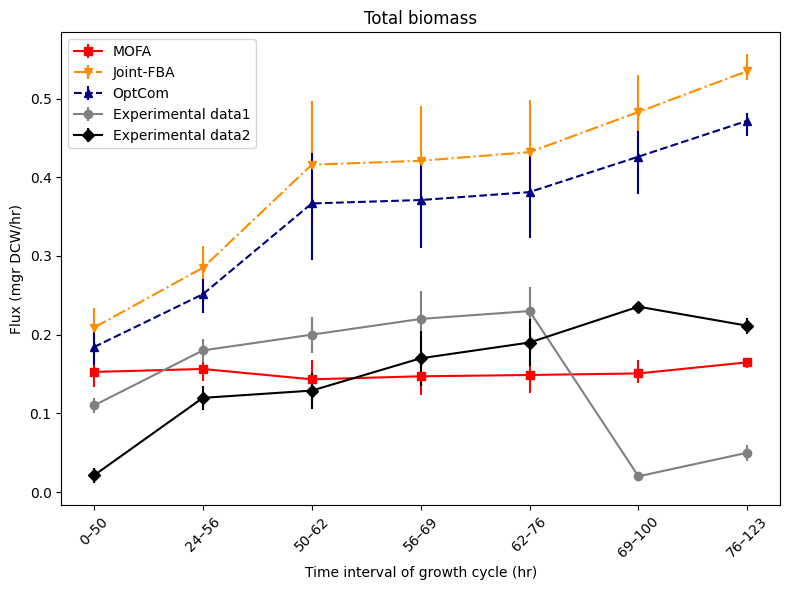

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

x_labels = ['0–50', '24–56', '50–62', '56–69', '62–76', '69–100', '76–123']
x = np.arange(len(x_labels))

avg_experience1 = np.array([0.11, 0.18, 0.2, 0.22, 0.23,0.02, 0.05])
error_exp1 = np.array([0.01, 0.015, 0.023, 0.035, 0.03, 0, 0.01])

avg_experience2 = np.array([0.0211395833333334, 0.119695095486111, 0.12892693236715, 0.1699775, 0.190022988505747,0.235569664902998, 0.21138268321513])


optcom_upper=np.array([0.2032869319, 0.2706559387, 0.4310671379, 0.4247889466, 0.4314571819,0.4592036302, 0.4819531351])
optcom_lower=np.array([0.1615032392,0.2270504928,0.2950855296,0.3100100008, 0.323272392,0.3785086418, 0.4523763691])
optcom_avg=np.array([0.184237698825,0.251366811168,0.3667472981,0.3711052514,0.3811753, 0.4262285222,0.4718857434])

Joint_fba_upper=np.array([0.183533613445378,0.257815384615385,0.335257383966245,0.351710416666667,0.366279918864097,0.435664246823956,0.513073770491803])
Joint_fba_lower=np.array([0.230953781512605,0.306923076923077,0.48884388185654,0.48151875,0.488957403651116,0.520693284936479,0.546401639344262])
Joint_fba_avg=np.array([0.209,0.285,0.416,0.421,0.432,0.483,0.535])

# Calculate the symmetric error bars
err_our = np.vstack((abs(our_lower-our_avg), abs(our_upper-our_avg)))
err_optcom = np.vstack((abs(optcom_lower-optcom_avg), abs(optcom_upper-optcom_avg)))
err_joint = np.vstack((abs(Joint_fba_lower-Joint_fba_avg), abs(Joint_fba_upper-Joint_fba_avg)))

plt.figure(figsize=(8, 6))

# darkorange line
plt.errorbar(x, our_avg, yerr=err_our, fmt='-s', color='red', label='MOFA')

# navy line
plt.errorbar(x, Joint_fba_avg, yerr=err_joint, fmt='-.v', color='darkorange', label='Joint-FBA')

plt.errorbar(x, optcom_avg, yerr=err_optcom, fmt='--^', color='navy', label='OptCom')


# Gray line
plt.errorbar(x, avg_experience1, yerr=error_exp1, fmt='-o', color='gray', label='Experimental data1')

# black line
plt.errorbar(x, avg_experience2, yerr=error_exp1, fmt='-D', color='black', label='Experimental data2')

plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Flux (mgr DCW/hr)")
plt.xlabel("Time interval of growth cycle (hr)")
plt.title("Total biomass")
plt.legend()
plt.tight_layout()
plt.savefig("Total_biomass_plot.png", dpi=600, bbox_inches='tight', format='png')  # or 'pdf' or 'svg'

plt.show()